## Project 3 - Processing Notebook for 'Warriors' and 'Lakers' Subreddit Dataframes
#### Stephen Strawbridge, Cohort #1019
---

In [1]:
#Standard packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Natural langauge toolkit
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

#Scikit learn
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import requests
from bs4 import BeautifulSoup

## Read in merged dataframe and train-test-split
---

In [2]:
#Read in dataframe
merged_df = pd.read_csv('./cleaned_dfs/merged_df.csv')
merged_df = merged_df.drop(columns = ['Unnamed: 0'])

In [3]:
#Source code is leveraged from GA lesson 5.04

#Define X and y
X = merged_df['whole_post']
y = merged_df['subreddit']

#Train-test-split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=35)

## Multinomial Naive Bayes Model - With TF-IDF Vectorizer
---

In [4]:
#Adding to list of stopwords, as described in further detail below
#Source code: https://medium.com/@tusharsri/remove-add-stop-words-7e2994c19c67#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjJlMzAyNWYyNmI1OTVmOTZlYWM5MDdjYzJiOTQ3MTQyMmJjYWViOTMiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2MDY3ODYwMTYsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExODAzOTU2ODk0Mjc2MDYwNDEzNCIsImVtYWlsIjoic3RlcGhlbnN0cmF3YnJpZGdlQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJuYW1lIjoiU3RlcGhlbiBTdHJhd2JyaWRnZSIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS0vQU9oMTRHZ041UTZGNk9TRFM3TllUSHdWa0pObTVHQ1FpWkR5THlkMVNHTlA9czk2LWMiLCJnaXZlbl9uYW1lIjoiU3RlcGhlbiIsImZhbWlseV9uYW1lIjoiU3RyYXdicmlkZ2UiLCJpYXQiOjE2MDY3ODYzMTYsImV4cCI6MTYwNjc4OTkxNiwianRpIjoiNTE1ODAwOGRjMTJmYWYzNDVkYTQzYjVjNzdkOWQxMzA1MmEzMjIzYyJ9.Hdn15nX8ADSK9JZBI-y2KgdjVRYZIv3_QIQdco0XA7-t-MEMANDGFpbkffLwlG0CciRwWN5pIgrG2y-9xcdnAQ9gMl0MEBKCLorh4iHWMcCHmLLUnl70yvXrzihlmugq3tKHeOD8JXnjIBsWGcYnoH_FMSwQZ7bAqx_6ldc7Lb_W77dBn1RlIvG2BKaRcu7xkM-bC1-Pru-7OaVw9SMdVqK_TiTeS1kaEgsJAdRWJQKXXHNikBuAnd8dQp9Wp6OC2UAPilHFF79hidc49SQXOdrkstbMDVZOmcQCj8QNe_pF0E47alEK3ClILnF0UUYH5KwyMQC6wey5-ZN_kzmdpA

#Import text package from sklearn
from sklearn.feature_extraction import text

#Create list of new stop words to include in the default English list of stop words
new_stop_words = ['www', 'com', 'https', 'reddit', 'think', 'like', 'index', 'wiki', 'just']
english_stops = (CountVectorizer(stop_words = 'english').get_stop_words)

#Create a final variable of STOP_WORDS to use
stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [5]:
#Source code is leveraged from GA lesson, 5.04
# Instantiate the transformer (TfidVectorizer)
tvec = TfidfVectorizer()

In [6]:
#Set up pipeline with tfidvectorizer as the transformer, and multinomial Naive Bayes as the estimator
tvec_pipe = Pipeline([
    ('tvec' , TfidfVectorizer(tokenizer = None,
                       stop_words = stop_words)),
    ('nb', MultinomialNB())
])

In [7]:
#Create pipe with best parameters to search over
pipe_params_tvec = {
    'tvec__max_features' : [9000],
    'tvec__ngram_range' : [(1,2)],
    'tvec__stop_words' : [stop_words]
}

In [8]:
#Instantiate GridSearchCV
gs_tvec = GridSearchCV(tvec_pipe,
                      pipe_params_tvec,
                      cv = 5)

In [9]:
#Fit GridSearch to training data
gs_tvec.fit(X_train, y_train);

In [22]:
#Find best parameters
gs_tvec.best_params_;

In [11]:
#Best score among the gridsearch
gs_tvec.best_score_

0.8734239963910555

In [12]:
#Find score on training and modeling set
train_score = gs_tvec.score(X_train, y_train)
test_score = gs_tvec.score(X_test, y_test)

print(f'Train Score: {round(train_score, 4)}')
print(f'Test Score: {round(test_score, 4)}')

Train Score: 0.9284
Test Score: 0.8694


In [13]:
#Recall Baseline score/accuracy
y_test.value_counts(normalize=True)

1    0.500502
0    0.499498
Name: subreddit, dtype: float64

In [14]:
#Source code is leveraged from GA lesson, 5.04
# Instantiate the transformer (TfidVectorizer)
tvec = TfidfVectorizer(tokenizer = None,
                      stop_words = stop_words,
                      max_features = 9000,
                      ngram_range = (1, 2))

## Further Analysis on Results
---

#### Confusion Matrix

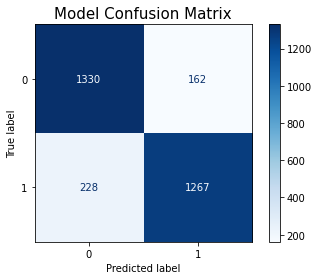

In [15]:
# Create predictions variable
preds = gs_tvec.predict(X_test)

# Create confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

#Create confusion matrix visual
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues');
plt.title('Model Confusion Matrix', size=15);

#### Which posts caused misclassification? 

In [16]:
#Create dataframe, starting with the y_test (actual subreddit) column
df_y_test = pd.DataFrame(data=y_test)
df_y_test = df_y_test.rename({'subreddit' : 'actual_subreddit'}, axis = 1)

#Append a predicted subreddit column with our predictions
df_y_test['predicted_subreddit'] = preds

#Append a misclassification column
df_y_test['misclass'] = df_y_test['actual_subreddit'] - df_y_test['predicted_subreddit']

#Append a 'whole_post' column, which is X_test (note X_test is in the same order and has the same number of rows)
df_y_test['whole_post'] = X_test

#Isolate dataframe for which there is a misclass (e.g. when misclass is not 0)
df_y_test = df_y_test[df_y_test['misclass'] != 0]

#Rename dataframe to more appropiate title
df_misclass = df_y_test

In [18]:
#Check format of the created dataframe from above
df_misclass.head()

,actual_subreddit,predicted_subreddit,misclass,whole_post
332,1,0,1,management making suite holders pay in full fo...
1395,1,0,1,[charania] sources: nba free agency will start...
7519,0,1,-1,get verified ✅[removed]
1069,1,0,1,fuck
4334,1,0,1,a fan shows true colors on the jumbotron


In [19]:
#Adding to list of stopwords, as described in further detail below
#Source code: https://medium.com/@tusharsri/remove-add-stop-words-7e2994c19c67#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjJlMzAyNWYyNmI1OTVmOTZlYWM5MDdjYzJiOTQ3MTQyMmJjYWViOTMiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2MDY3ODYwMTYsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExODAzOTU2ODk0Mjc2MDYwNDEzNCIsImVtYWlsIjoic3RlcGhlbnN0cmF3YnJpZGdlQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJuYW1lIjoiU3RlcGhlbiBTdHJhd2JyaWRnZSIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS0vQU9oMTRHZ041UTZGNk9TRFM3TllUSHdWa0pObTVHQ1FpWkR5THlkMVNHTlA9czk2LWMiLCJnaXZlbl9uYW1lIjoiU3RlcGhlbiIsImZhbWlseV9uYW1lIjoiU3RyYXdicmlkZ2UiLCJpYXQiOjE2MDY3ODYzMTYsImV4cCI6MTYwNjc4OTkxNiwianRpIjoiNTE1ODAwOGRjMTJmYWYzNDVkYTQzYjVjNzdkOWQxMzA1MmEzMjIzYyJ9.Hdn15nX8ADSK9JZBI-y2KgdjVRYZIv3_QIQdco0XA7-t-MEMANDGFpbkffLwlG0CciRwWN5pIgrG2y-9xcdnAQ9gMl0MEBKCLorh4iHWMcCHmLLUnl70yvXrzihlmugq3tKHeOD8JXnjIBsWGcYnoH_FMSwQZ7bAqx_6ldc7Lb_W77dBn1RlIvG2BKaRcu7xkM-bC1-Pru-7OaVw9SMdVqK_TiTeS1kaEgsJAdRWJQKXXHNikBuAnd8dQp9Wp6OC2UAPilHFF79hidc49SQXOdrkstbMDVZOmcQCj8QNe_pF0E47alEK3ClILnF0UUYH5KwyMQC6wey5-ZN_kzmdpA

#Import text package from sklearn
from sklearn.feature_extraction import text

#Create list of new stop words to include in the default English list of stop words
new_stop_words = ['www', 'com', 'https', 'reddit', 'think', 'like', 'index', 'wiki', 'just']
english_stops = (CountVectorizer(stop_words = 'english').get_stop_words)

#Create a final variable of STOP_WORDS to use
STOP_WORDS = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [20]:
#Apply cvec transformer to whole_post column
cvec = CountVectorizer(stop_words = STOP_WORDS)

cvec.fit(df_misclass['whole_post'])

X_trans = cvec.transform(df_misclass['whole_post'])

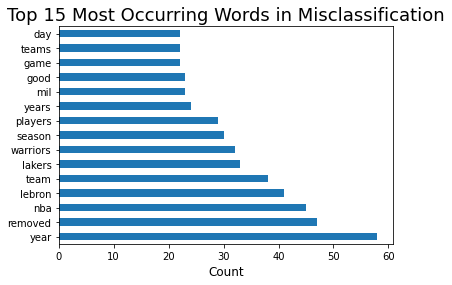

In [21]:
df_misclass = pd.DataFrame(X_trans.toarray(), 
                           columns=cvec.get_feature_names())

#Observe the top 15 occurring words
plt.title('Top 15 Most Occurring Words in Misclassification', size=18)
plt.xlabel('Count', size=12)
df_misclass.sum().sort_values(ascending=False).head(15).plot(kind='barh');

#### Interesting that opposing team key words were common in misclassified posts
#### This is because people in the warriors subreddit, for example, talk about Lebron all the time!